# PLSC 597 - Final Project
### Maya Dalton (12/11/23)

Please find my Jupyter Notebook file and data file for this assignment [here.](https://github.com/mad6821/PLSC-597---Machine-Learning)

## 1. Data Cleaning and EDA

### A. Import Libraries and Data

In [90]:
# Importing libraries, storing as shorthand
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.inspection import permutation_importance

# Read the .dta file into a pandas DataFrame
df = pd.read_csv('dalton_df.csv')
print(df.head())

   country    yr  elect_yr  elect_vio           electID  polity2  elect_sys  \
0  Albania  1992      1992          1  339-1992-0322-L1        5          6   
1  Albania  1992      1992          1  339-1992-0322-L1        5          6   
2  Albania  1992      1992          1  339-1992-0322-L1        5          6   
3  Albania  1992      1992          1  339-1992-0322-L1        5          6   
4  Albania  1992      1992          1  339-1992-0322-L1        5          6   

   party_comp  elect_monitor  cand_restrict  social_power      gdppc  \
0           6              0              1         0.939  200.85222   
1           6              0              1         0.939  200.85222   
2           6              0              1         0.939  200.85222   
3           6              0              1         0.939  200.85222   
4           6              0              1         0.939  200.85222   

   regime_type  
0            5  
1            5  
2            5  
3            5  
4      

---
### EDA

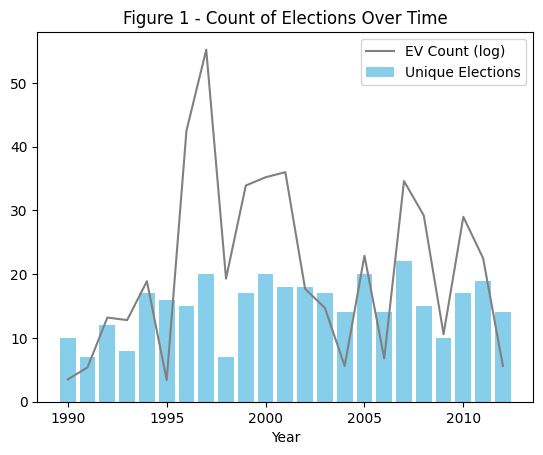

In [39]:
# Count of elections and EV by year
elect_by_year = df.groupby('yr')['electID'].nunique()
violence_by_year = df.groupby('yr')['elect_vio'].sum()

# Plotting
plt.bar(elect_by_year.index, elect_by_year.values, color='skyblue', label='Unique Elections')
plt.plot(violence_by_year.index, violence_by_year.values/10, linestyle='-', color='gray', label='EV Count (log)')
plt.xlabel('Year')
plt.ylabel('')
plt.title('Figure 1 - Count of Elections Over Time')
plt.legend()
plt.show()

---
### Data Cleaning and Splitting

In [ ]:
# One-Hot Encoding for nominal variables: state, ethnicity, and area
df = df.drop('electID', axis=1)  # drop EV only
df_encoded = pd.get_dummies(df, columns=['country'])
print(df_encoded.head())

In [ ]:
# Separate features/predictors and target variable
X = df_encoded.drop('elect_vio', axis=1)  # drop EV only
y = df_encoded[['elect_vio']]  # keep EV only

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=918)
y_train = np.ravel(y_train)

# Display the first few rows of the training and test sets for our predictors
print("Training Data:")
print(X_train.head())
print("\nTest Data:")
print(X_test.head())

---
## 2. Comparing ML Algorithms

### A. MSE and Accuracy Scores

In [93]:
###### Regularized (L2) Logit
reg_lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42))
reg_lr_pipe.fit(X_train, y_train)
preds = reg_lr_pipe.predict(X_test)

mse = mean_squared_error(y_test, preds)
test_acc = reg_lr_pipe.score(X_test, y_test)
scores = cross_val_score(reg_lr_pipe, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()

print(f"MSE: {mse:.5f}")
print(f"CV Training Accuracy: {mean_accuracy:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

MSE: 0.25698
CV Training Accuracy: 0.75131
Test Accuracy: 0.74302


In [ ]:
###### SVM
svm_pipe = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
svm_pipe.fit(X_train, y_train)
preds = svm_pipe.predict(X_test)

mse = mean_squared_error(y_test, preds)
test_acc = svm_pipe.score(X_test, y_test)
scores = cross_val_score(svm_pipe, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()

print(f"MSE: {mse:.5f}")
print(f"CV Training Accuracy: {mean_accuracy:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

In [95]:
###### Random Forest
rf_pipe = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))
rf_pipe.fit(X_train, y_train)
preds = rf_pipe.predict(X_test)

mse = mean_squared_error(y_test, preds)
test_acc = rf_pipe.score(X_test, y_test)
scores = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()

print(f"MSE: {mse:.5f}")
print(f"CV Training Accuracy: {mean_accuracy:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

MSE: 0.24651
CV Training Accuracy: 0.74944
Test Accuracy: 0.75349


### ROC and PR Plots

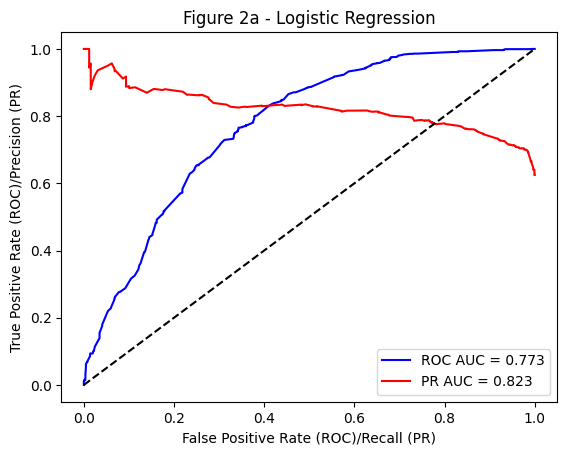

Area under the ROC curve: 0.77341
Area under the precision recall curve: 0.82304


In [96]:
##### Logit Model

# Calculate ROC AUC
probs = reg_lr_pipe.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Calculate PRC AUC
y_score = reg_lr_pipe.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)

# Plot
plt.title('Figure 2a - Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'ROC AUC = %0.3f' % roc_auc)
plt.plot(recall, precision, 'r', label = 'PR AUC = %0.3f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate (ROC)/Precision (PR)')
plt.xlabel('False Positive Rate (ROC)/Recall (PR)')
plt.show()

#print(f'Area under the ROC curve: {roc_auc:.5f}')
#print(f'Area under the precision recall curve: {pr_auc:.5f}')

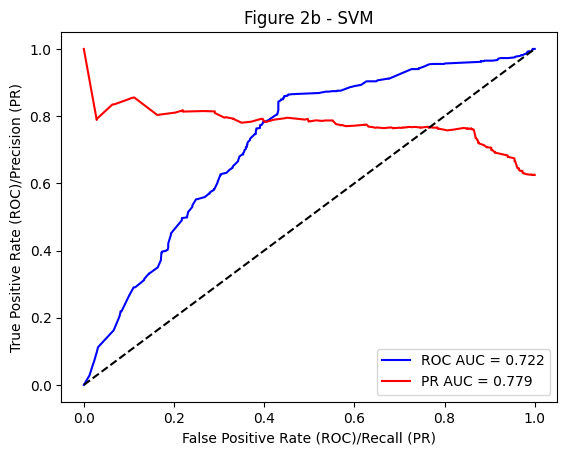

Area under the ROC curve: 0.72168
Area under the precision recall curve: 0.77880


In [97]:
##### SVM Model

# Calculate ROC AUC
probs = svm_pipe.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Calculate PRC AUC
y_score = svm_pipe.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)

# Plot
plt.title('Figure 2b - SVM')
plt.plot(fpr, tpr, 'b', label = 'ROC AUC = %0.3f' % roc_auc)
plt.plot(recall, precision, 'r', label = 'PR AUC = %0.3f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate (ROC)/Precision (PR)')
plt.xlabel('False Positive Rate (ROC)/Recall (PR)')
plt.show()

#print(f'Area under the ROC curve: {roc_auc:.5f}')
#print(f'Area under the precision recall curve: {pr_auc:.5f}')

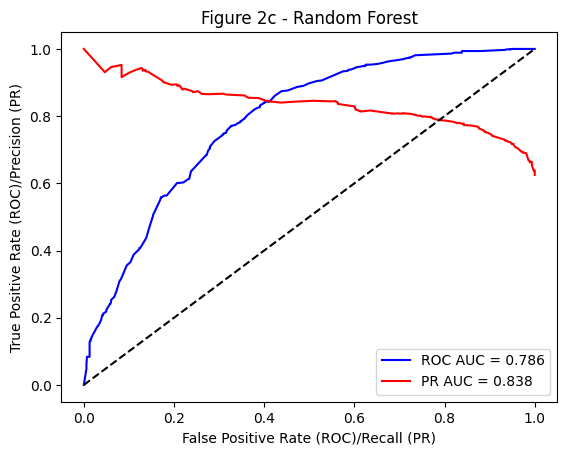

Area under the ROC curve: 0.78642
Area under the precision recall curve: 0.83823


In [98]:
##### Random Forest

# Calculate ROC AUC
probs = rf_pipe.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Calculate PRC AUC
y_score = rf_pipe.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)

# Plot
plt.title('Figure 2c - Random Forest')
plt.plot(fpr, tpr, 'b', label = 'ROC AUC = %0.3f' % roc_auc)
plt.plot(recall, precision, 'r', label = 'PR AUC = %0.3f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate (ROC)/Precision (PR)')
plt.xlabel('False Positive Rate (ROC)/Recall (PR)')
plt.show()

#print(f'Area under the ROC curve: {roc_auc:.5f}')
#print(f'Area under the precision recall curve: {pr_auc:.5f}')

---
## 3. Comparison with Fjeld & Hoglund

---
### Data Clean and Replicate

In [99]:
####### Cleaning dataset
fh_df = pd.read_stata('fjeld_hoglund.dta')

# Create lagged variables
fh_df['l12_polity2'] = fh_df['polity2'].shift(1)
fh_df['l12_politysq'] = fh_df['politysq'].shift(1)
fh_df['l12_lnpop'] = fh_df['lnpop'].shift(1)
fh_df['l12_lngdpc'] = fh_df['lngdpc'].shift(1)
fh_df['l_cw'] = fh_df['cw'].shift(1)
fh_df['l_riots_alt'] = fh_df['riots_alt'].shift(1)

# Rename columns
fh_df = fh_df.rename(columns={'iaep_maj': 'Majoritarian system',  'i_lnmdmh':'Mean district magnitude (log)',
                              'iaep4':'Mixed System', 'l12_polity2':'Democracy index (lag)',
                              'l12_politysq':'Democracy index sq (lag)', 'l12_lnpop':'Population (log, lag)',
                              'l12_lngdpc':'GDP (log, lag)', 'l_cw':'Armed conflict (t-1)',
                              'l_riots_alt':'Opp. Violence (t-1)'})

In [ ]:
###### Split the data into training and testing sets
df_subset = fh_df[fh_df['sample'] == 1]
df_subset = df_subset.dropna()

# Define the independent variables (features)
independent_vars = ['Majoritarian system', 'Democracy index (lag)', 'Mixed System',
                    'Democracy index sq (lag)', 'Population (log, lag)', 'GDP (log, lag)', 'Armed conflict (t-1)',
                    'Opp. Violence (t-1)']

# Add a constant term to the independent variables
X = sm.add_constant(df_subset[independent_vars])

# DV: Opposition Violence
y = df_subset['riots_alt']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=918)
y_train = np.ravel(y_train)

In [ ]:
##### Fit the original logit model & check against paper
logit_model = sm.Logit(y, X)
result = logit_model.fit(cov_type='cluster', cov_kwds={'groups': df_subset['ccode']})
print(result.summary())

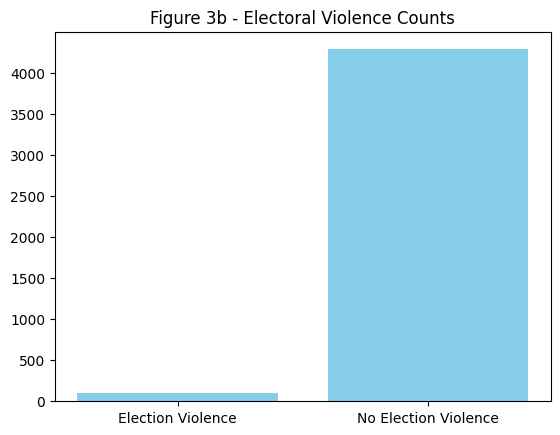

In [116]:
###### Check class imbalance
ev = len(np.argwhere(df_subset.riots_alt.to_numpy()))
no_ev = len(df_subset.riots_alt) - ev

plt.bar(['Election Violence', 'No Election Violence'],[ev, no_ev], color = 'skyblue')
plt.title('Figure 3b - Electoral Violence Counts')
plt.show()

---
### Comparison of RF and Logit

In [102]:
####### Train, and Test Accuracy of Logit
# Fit Model
logit_model = LogisticRegression(max_iter=1000, random_state=42)
logit_model.fit(X_train, y_train)

# Training accuracy
scores = cross_val_score(logit_model, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()

# Test accuracy
lr_preds = logit_model.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)

print(f"Training Accuracy: {mean_accuracy:.5f}")
print(f"Test Accuracy: {lr_acc:.5f}")

Training Accuracy: 0.97591
Test Accuracy: 0.97570


In [113]:
###### MSE, Train, and Test Accuracy of RF with class imbalance

rf_pipe = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model = rf_pipe.fit(X, y)
preds = rf_model.predict(X_test)

mse = mean_squared_error(y_test, preds)
test_acc = rf_pipe.score(X_test, y_test)
scores = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()

print(f"MSE: {mse:.3f}")
print(f"Training Accuracy: {mean_accuracy:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

MSE: 0.025
Training Accuracy: 0.97428
Test Accuracy: 0.97494


In [118]:
###### MSE, Train, and Test Accuracy of RF with class weights

rf_pipe_bal = make_pipeline(RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
rf_model = rf_pipe_bal.fit(X, y)
preds = rf_model.predict(X_test)

mse = mean_squared_error(y_test, preds)
test_acc = rf_pipe_bal.score(X_test, y_test)
scores = cross_val_score(rf_pipe_bal, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()

print(f"MSE: {mse:.3f}")
print(f"Training Accuracy: {mean_accuracy:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

MSE: 0.134
Training Accuracy: 0.90755
Test Accuracy: 0.86560


---
### RF AUC and Permutation Plots

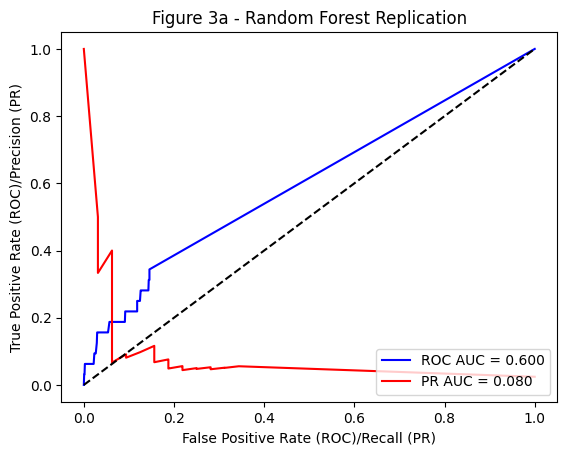

In [119]:
####### Random Forest ROC and PR AUC Plot
y_test = np.ravel(y_test)
rf_pipe.fit(X_train, y_train)

# Calculate ROC AUC
probs = rf_pipe.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Calculate PRC AUC
y_score = rf_pipe.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)

plt.title('Figure 3a - Random Forest Replication')
plt.plot(fpr, tpr, 'b', label = 'ROC AUC = %0.3f' % roc_auc)
plt.plot(recall, precision, 'r', label = 'PR AUC = %0.3f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate (ROC)/Precision (PR)')
plt.xlabel('False Positive Rate (ROC)/Recall (PR)')
plt.show()

#print(f'Area under the ROC curve: {roc_auc:.5f}')
#print(f'Area under the precision recall curve: {pr_auc:.5f}')

<Figure size 1500x600 with 0 Axes>

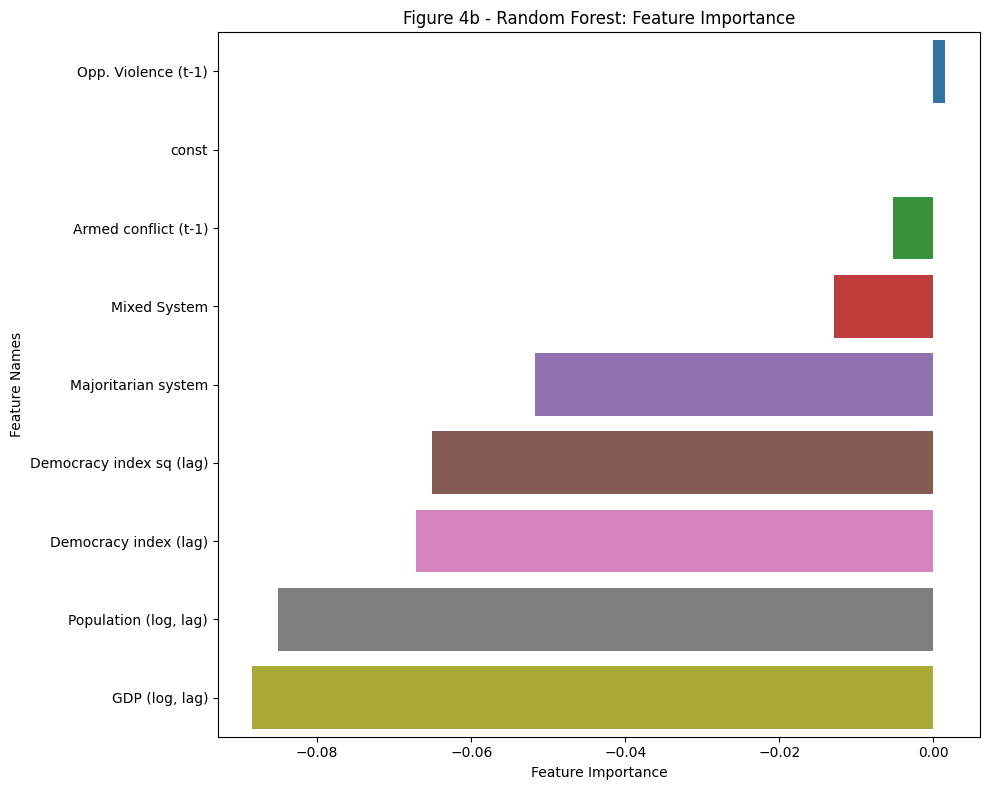

In [124]:
####### Random Forest Feature Importance

# Function to plot permutation importances
def plot_perm_importance(importance, names, model_type, title):
    feature_importance = np.array(importance.importances_mean)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title('Figure 4b - ' + model_type + ': Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# Permutation importance for Random Forest
rf_perm_importance = permutation_importance(rf_pipe_bal, X_test, y_test, n_repeats=30, random_state=918)

# Get feature names (assuming X is a DataFrame)
feature_names = X.columns

# Plot permutation importances side by side
plt.figure(figsize=(15, 6))
plot_perm_importance(rf_perm_importance, feature_names, 'Random Forest', 'Permutation Importance')
plt.tight_layout()
plt.show()

---
### LR Permutation Plot

Text(0, 0.5, 'Feature Names')

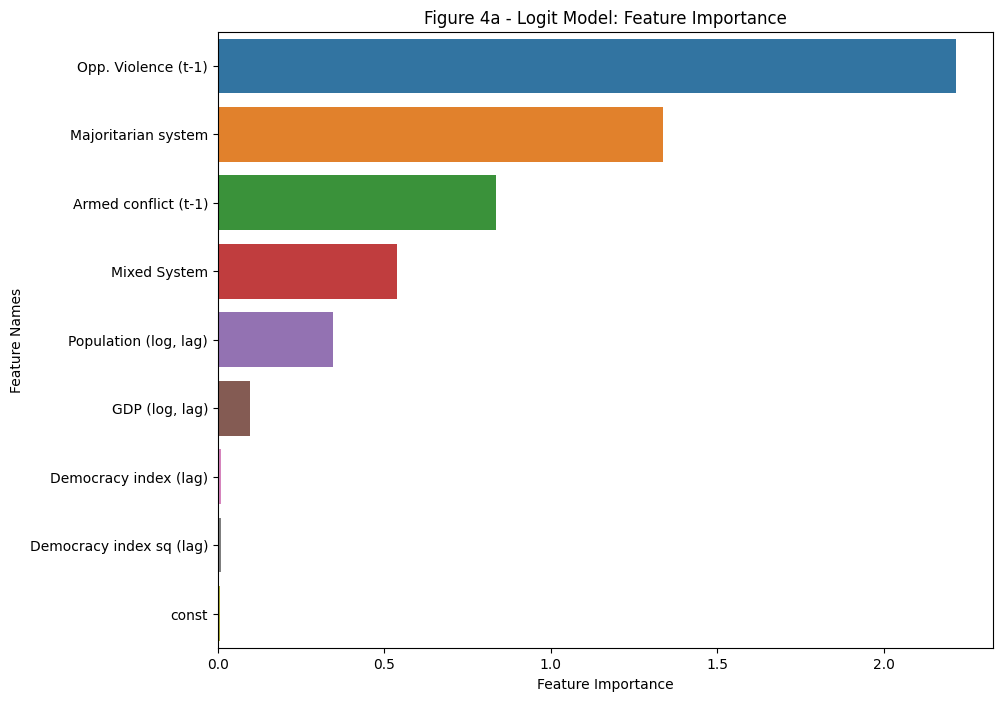

In [125]:
####### Logit Model Feature Importance
coefficients = logit_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
plt.title("Figure 4a - Logit Model: Feature Importance")
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')